**MONTHLY RENTAL CONDOMINIUM**
---
web scraping from https://www.livinginsider.com

# TASK 1 : import library
---

In [20]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TASK 2 : scrape from website
---

In [ ]:
list_link = []
for i in range(1,2092):
    list_link.append('https://www.livinginsider.com/searchword/Condo/Rent/' + str(i) + '/%E0%B8%A3%E0%B8%A7%E0%B8%A1%E0%B8%9B%E0%B8%A3%E0%B8%B0%E0%B8%81%E0%B8%B2%E0%B8%A8-%E0%B9%80%E0%B8%8A%E0%B9%88%E0%B8%B2-%E0%B8%84%E0%B8%AD%E0%B8%99%E0%B9%82%E0%B8%94.html')

In [ ]:
# scrape title of each condominium
condo_title = []
def def_title(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'col-md-12 col-sm-12'})
    for t in raw_data:
        condo_title.append(t.text)
    return condo_title

In [ ]:
# scrape rental price of each condominium post
condo_price = []
def def_price(soupsoup):
    raw_data = soupsoup.find_all('div',{'class':'t-16'})
    for p in raw_data:
        condo_price.append(int(p.text.replace(',','').replace('฿','')))
    return condo_price

In [ ]:
# scrape reach of each condominium post
condo_reach = []
def def_reach(soupsoup):
    raw_data = soupsoup.find_all('div',attrs={'class':'istock-view pull-right'})
    for r in raw_data:
        condo_reach.append(r.text.split()[0])
    return condo_reach     

In [ ]:
# scrape create date of each condominium post
condo_cdate = []
def def_cdate(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'istock-lastdate pull-left'})
    for d in raw_data:
        condo_cdate.append(d.text.split())
    return condo_cdate

In [ ]:
# scrape location of each condominium post (location means group of this location)
condo_location = []
def def_location(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'col-md-12 col-sm-12 col-xs-12 ic-detail-zone'})
    for l in raw_data:
        condo_location.append(l.find('span').text)
    return condo_location

In [ ]:
# scrape detail date of each condominium post. This list have area of room, number of bedroom, number of bathroom and floor level 
condo_detail = []
def def_detail(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'col-md-12 col-sm-12 div-ic-detail'})
    for dt in raw_data:
        condo_detail.append(dt.text.split())
    return condo_detail

In [ ]:
# run to collect data 
for i in range(1,2092):
    r = requests.get(list_link[i-1])
    soup = BeautifulSoup(r.text, 'lxml')
    def_title(soup)
    def_price(soup)
    def_reach(soup)
    def_cdate(soup)
    def_location(soup)
    def_detail(soup)

# TASK 3 : clean data
---

In [ ]:
tt = []
for t in condo_title:
    tt.append(t.replace('\n', '').lstrip().rstrip())

for i in tt[:]:
    if i == '':
        tt.remove(i)
    elif i in ['แพ็กเกจพิเศษ ติดต่อสอบถามได้ที่Sale@Livinginsider.com', 'Foreigner Quota']:
        tt.remove(i)

condo_title = tt

In [ ]:
raw_data = pd.DataFrame([condo_title,condo_price,condo_reach,condo_location]).transpose()
raw_data_c = pd.DataFrame(condo_cdate)
raw_data_d = pd.DataFrame(condo_detail)

In [ ]:
raw_data = pd.merge(raw_data,raw_data_c,left_index=True, right_index=True)
raw_data = pd.merge(raw_data,raw_data_d,left_index=True, right_index=True)

In [ ]:
raw_data = raw_data.rename(columns={'0_x':'title', '1_x':'rent_price', '2_x':'reach', '3_x':'location_zone', 
                         '0_y':'cdate', '1_y':'ctime', 0:'area_mm', 1:'mm_measure', '2_y':'floor', 
                         '3_y':'floor_level', 4:'unit_room',5:'roomtype', 6:'unit_bath', 7:'bathroom' })

In [ ]:
raw_data = raw_data.drop_duplicates(keep='last', ignore_index=True)

 *change reach format (eg. 5k to 5000)*


In [ ]:
new_condo_reach = []
for r in raw_data['reach']:
    if r[-1] == 'k':
        y = float(r.replace('k',''))
        new_condo_reach.append(int(y * 1000))
    else:
        new_condo_reach.append(int(r))

In [ ]:
new_condo_reach = pd.DataFrame(new_condo_reach).reset_index()

In [ ]:
#merge to raw_data
raw_data = pd.merge(raw_data, new_condo_reach, on='index', how='inner')

In [ ]:
#drop reach column
raw_data = raw_data.drop(columns=['reach'])

 *merge cdate and ctime to datetime datatype before starting clean cdate and ctime unformat*

 find different day starting from crete post date, To current days just scrape data.

In [ ]:
for i in ['วินาทีที่แล้ว', 'นาทีที่แล้ว', 'ชั่วโมงที่แล้ว', 'เมื่อวานนี้']
    clean_oldtime_data = raw_data[raw_data['ctime'] != i ]

In [ ]:
raw_data = clean_oldtime_data.reset_index()

In [ ]:
raw_data['to_date'] = pd.to_datetime(raw_data['to_date'])
raw_data['from_date'] = raw_data['cdate'].map(str) + ' ' + raw_data['ctime'].map(str) 
raw_data['from_date'] = pd.to_datetime(raw_data['from_date'])
raw_data = raw_data.drop(columns=['cdate', 'ctime'])
raw_data['diff_day'] = (raw_data['to_date'] - raw_data['from_date']) / np.timedelta64(1, 'D')

 *merge unit_room, roomtype, unit_bath and bathroom to separate into bedroom_unit and bathroom_unit numberical format*

In [ ]:
raw_data['room_detail'] = raw_data['unit_room'].map(str) + raw_data['roomtype'].map(str) + raw_data['unit_bath'].map(str) + raw_data['bathroom'].map(str)
raw_data = raw_data.drop(columns=['unit_room', 'roomtype', 'unit_bath', 'bathroom'])

In [ ]:
bedroom_unit = []
for i in raw_data['room_detail']:
    if i[0] == '1':
        bedroom_unit.append(1)
    elif i[0] == '2':
        bedroom_unit.append(2)
    elif i[0] == '3':
        bedroom_unit.append(3)
    elif i[0] == '4':
        bedroom_unit.append(4)
    elif i[0] == '5':
        bedroom_unit.append(5)
    elif i[0] == '8':
        bedroom_unit.append(8)
    else:
        bedroom_unit.append(0)
bedroom_unit = pd.DataFrame(bedroom_unit)

In [ ]:
bathroom_unit = []
for i in raw_data['room_detail']:
    if i[8] in ('1', '2', '3', '4', '5'):
        bathroom_unit.append(i[8])
    elif i[11] in ('1', '2', '3'):
        bathroom_unit.append(i[11])
    else:
        bathroom_unit.append(i[9])
bathroom_unit = pd.DataFrame(bathroom_unit)

In [ ]:
raw_data = pd.merge(raw_data, bedroom_unit, on='index', how='inner' )
raw_data = pd.merge(raw_data, bathroom_unit, on='index', how='inner' )

 *change datatype to correct format*

In [ ]:
raw_data['rent_price'] = raw_data['rent_price'].astype('int')
raw_data['area_mm'] = raw_data.to_numeric(df['area_mm'])
raw_data['new_reach'] = raw_data['new_reach'].astype('int')
raw_data['bedroom_unit'] = raw_data['bedroom_unit'].astype('int')
raw_data['bathroom_unit'] = raw_data['bathroom_unit'].astype('int')

 *export csv file to visualize in tableau*

In [ ]:
raw_data.to_csv('/lvinsider_data.csv')

# TASK 3 : Visualize 
---

# TASK 4: Analyzed correlation two independent variable
---
analyzed only top 15 location_zone to find correlation

In [2]:
df_temp = pd.read_csv('/Users/natthakitngamcharoensin/Documents/projects/pythonxlivinginsider/lvinsider_data.csv')

In [3]:
df_temp = raw_data
df_temp

,title,rent_price,location_zone,area_mm,floor_level,bedroom_unit,bathroom_unit,new_reach,to_date,from_date,diff_day
0,ให้เช่า คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,7000,สมุทรปราการ สำโรง,24.00,13,1,1,1200,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
1,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,24.00,11,1,1,1100,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
2,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.50,26,1,1,938,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
3,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.00,16,1,1,691,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
4,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.50,22,1,1,928,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
...,...,...,...,...,...,...,...,...,...,...,...
91005,1 ห้องนอน 35 ตร.ม. ราคาดีที่สุด,12000,บางนา แบริ่ง ลาซาล,35.01,14,1,1,35200,2022-05-06 18:00:00,2022-04-01 23:04:00,34.788889
91006,ใช้ชีวิต เหนือระดับ 2 ห้องนอน 185 ราชดำริ,120000,วิทยุ ชิดลม หลังสวน,119.00,27,2,2,36200,2022-05-06 18:00:00,2022-03-27 23:27:00,39.772917
91007,"ให้เช่า 2 นอน 100 ตร.ม. ไฮฟ์ ตากสิน 35,000",35000,วงเวียนใหญ่ เจริญนคร,100.01,27,2,2,37100,2022-05-06 18:00:00,2022-03-27 23:28:00,39.772222
91008,พิเศษ ห้องใหม่ ให้เช่า 2 นอน 50 ตร.ม. โว้คเพลส...,20000,บางนา แบริ่ง ลาซาล,50.01,7,2,1,39100,2022-05-06 18:00:00,2022-03-27 23:28:00,39.772222


 *select only top 15 location*

In [5]:
locat = ['สมุทรปราการ สำโรง', 'เสรีไทย-นิด้า', 'นานา', 'บางแค เพชรเกษม',
       'วิภาวดี ดอนเมือง หลักสี่ ', 'สีลม ศาลาแดง บางรัก',
       'พระราม 2 บางขุนเทียน', 'พระราม 5 ราชพฤกษ์ บางกรวย',
       'เกษตร นวมินทร์ ลาดปลาเค้า', 'นนทบุรี บางใหญ่ บางบัวทอง',
       'เลียบทางด่วนรามอินทรา', 'ปิ่นเกล้า จรัญสนิทวงศ์', 'นวมินทร์ รามอินทรา',
       'พัฒนาการ ศรีนครินทร์',
       'แจ้งวัฒนะ เมืองทอง', 'เกษตรศาสตร์ รัชโยธิน',
       'รัตนาธิเบศร์ สนามบินน้ำ พระนั่งเกล้า', 'พระราม 3 สาธุประดิษฐ์',
       'คลองเตย กล้วยน้ำไท', 'รามคำแหง หัวหมาก', 'ลาดกระบัง สุวรรณภูมิ', 'ปทุมธานี รังสิต ธรรมศาสตร์',
       'พระราม 8 สามเสน ราชวัตร', 'โชคชัย4 ลาดพร้าว71',
       'มีนบุรี-ร่มเกล้า', 'ลาดพร้าว101 แฮปปี้แลนด์',
       'นครปฐม พุทธมณฑล ศาลายา', 'ราษฎร์บูรณะ สุขสวัสดิ์',
       'เยาวราช บางลำพู']
for i in locat:
    df_temp = df_temp.loc[df_temp['location_zone'] != i ] 

In [6]:
df_temp['reach_per_day'] = df_temp['new_reach'] / df_temp['diff_day']

In [7]:
#change the type to stored categorically
df_temp.location_zone = pd.Categorical(df_temp.location_zone)

In [9]:
#create bin stored interval of area and change to catagory format
df_temp['area_bins'] = pd.qcut(df_temp['area_mm'], 15)

In [17]:
df_temp = df_temp.drop(columns=['title', 'floor_level', 'to_date', 'from_date'])

<Figure size 1080x720 with 0 Axes>

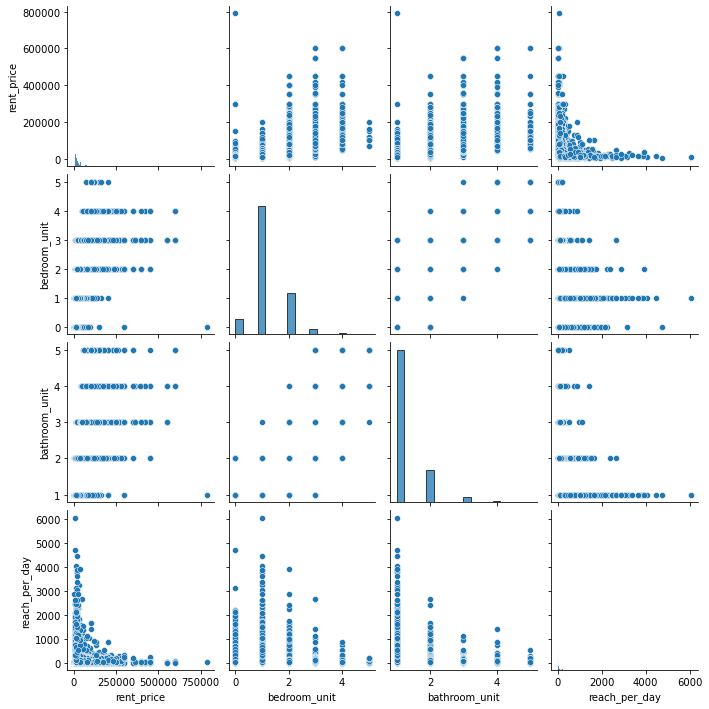

In [21]:
plt.figure(figsize=(15,10))
sns.pairplot(df_temp)

In [22]:
df_temp.corr()

,rent_price,bedroom_unit,bathroom_unit,reach_per_day
rent_price,1.000000,0.566633,0.675882,-0.007150
bedroom_unit,0.566633,1.000000,0.773595,-0.003724
bathroom_unit,0.675882,0.773595,1.000000,-0.006395
reach_per_day,-0.007150,-0.003724,-0.006395,1.000000


<AxesSubplot:>

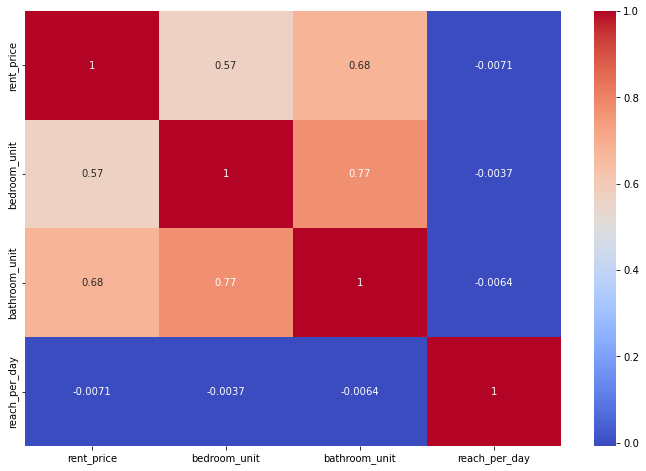

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='rent_price', ylabel='reach_per_day'>

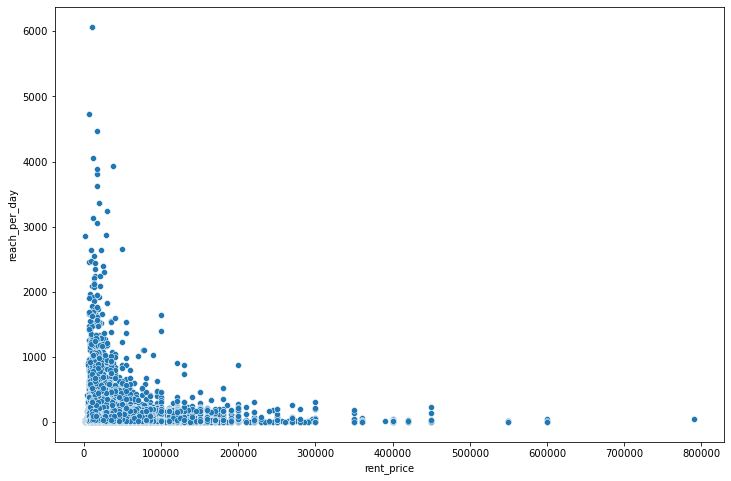

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_temp, x='rent_price', y='reach_per_day')

 **Test about rental price and reach/day on each post**
 * H0 : There is no relationship between two variables
 * H1 : There is a relationship between two variables
 
 Use a correlation testing. A correlarion give two things, correlation coefficient, and a p-value.


In [37]:
from scipy.stats import stats

In [39]:
pearson_coef, p_value = stats.pearsonr(df_temp["reach_per_day"], df_temp["rent_price"])

print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )

Pearson Correlation Coefficient:  -0.007149504500568178 and a P-value of: 0.058


As we can see the p-value is more than 0.05 hence, we accept the null hypothesis at a 95% level of confidence. **That means that there is no relationship between rental price and reach/day on each post.**